In [36]:
import os
import sys
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


In [4]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from global_config import *
from src.utils.helpers import get_emotion_abrs_from_ids, mapper

In [6]:
input_path = os.path.join(ROOT_DIR,'files/tests/preprocessing/dataset_creation/video_data_functionals_A220.npz')
output_path = os.path.join(ROOT_DIR,'files/out/functionals/unsupervised_learning/video')

In [9]:
npz_file = np.load(input_path, allow_pickle=True)
_X = npz_file['x']
y = npz_file['y']
col_names = npz_file['col_names']

scaler = MinMaxScaler()
X = scaler.fit_transform(_X)

# Dimensionality Reduction

## Exploration 

### Standard deviation

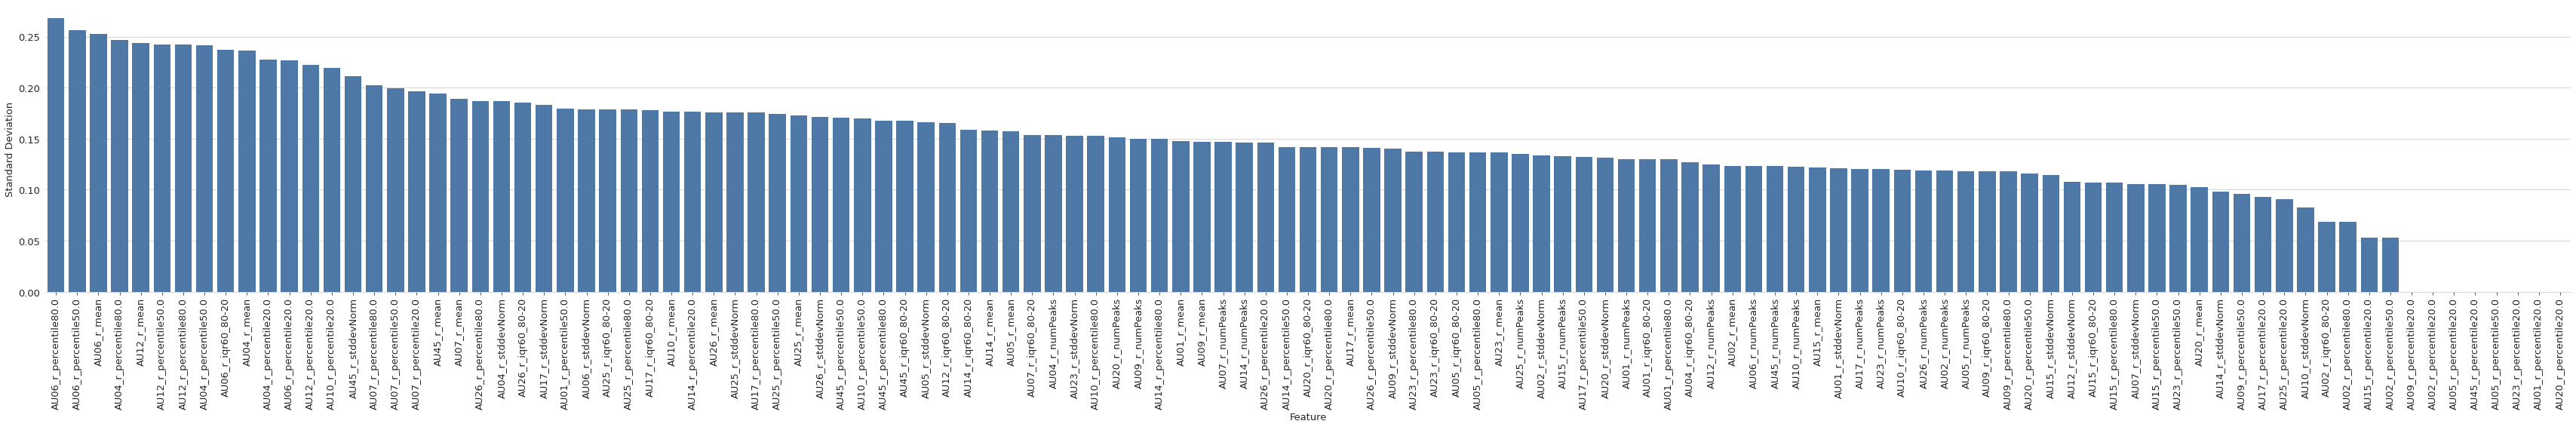

In [17]:
XX = pd.DataFrame(data=X, columns=col_names)
std = XX.std().sort_values(ascending=False)

plt.figure(figsize=[60,7])
#matplotlib.rcParams.update({'font.size': 14.5})
sns.set_style({'xtick.bottom': True})
sns.barplot(x=std.index, y=std.values, color=blue_rgb, saturation=sns_saturation)
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Standard Deviation')
plt.savefig(os.path.join(output_path,'charts','report_std_expl_dim_red.svg'), bbox_inches = 'tight')
sns.set_style({'xtick.bottom': False})
matplotlib.rcParams.update({'font.size': 13})

### Pairwise correlations

/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


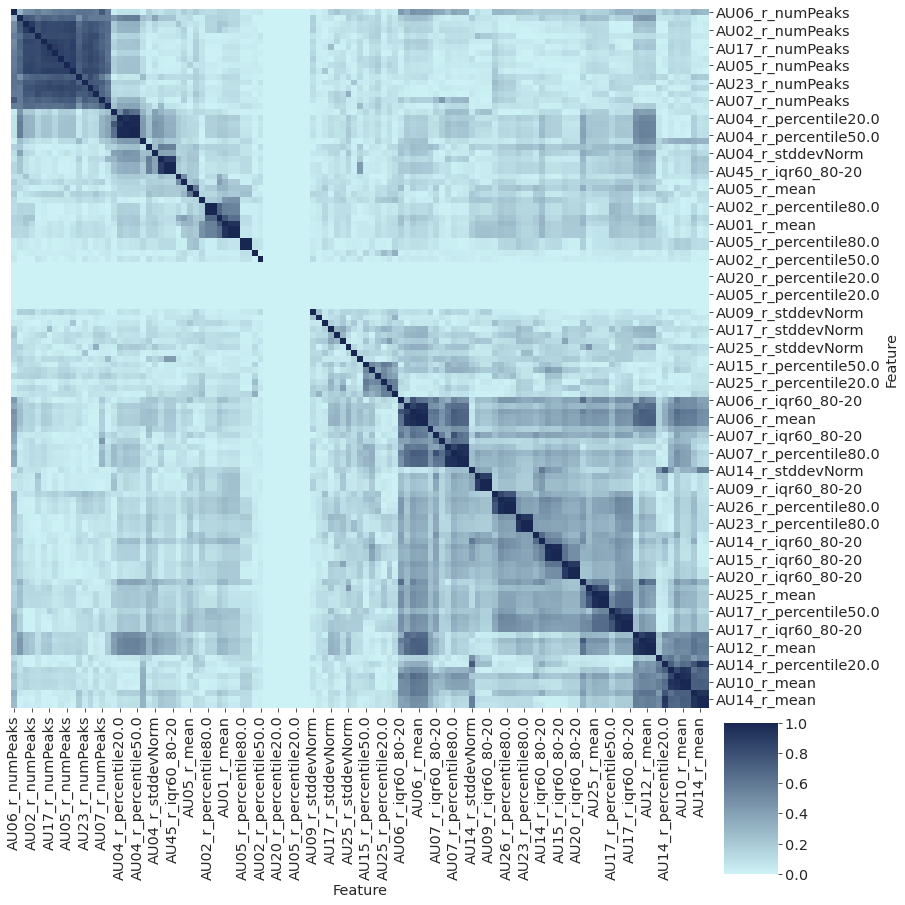

In [35]:
XX = pd.DataFrame(data=X, columns=col_names)

# Create correlation matrix
corr_matrix = XX.corr().abs()

corr_matrix = corr_matrix.fillna(0)

matplotlib.rcParams.update({'font.size': 14.5})
sns.set_style({'ytick.right': True})
sns.set_style({'xtick.bottom': True})
cg=sns.clustermap(corr_matrix, cmap=pos_cmap, metric='cityblock', cbar_pos=(0.84, 0.02, 0.05, 0.14), figsize=(15,15))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlabel("Feature")
ax.set_ylabel("Feature")
plt.savefig(os.path.join(output_path,'charts','report_corr_expl_dim_red.svg'), bbox_inches = 'tight')
sns.set_style({'ytick.right': False})
sns.set_style({'xtick.bottom': False})
matplotlib.rcParams.update({'font.size': 13})

### PCA

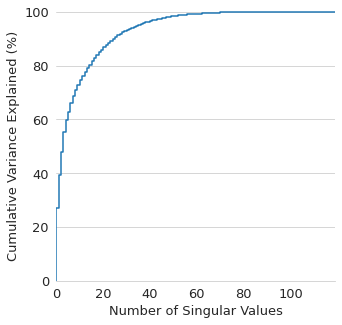

In [37]:
XX = pd.DataFrame(data=X, columns=col_names)
pca = PCA().fit(XX)

expl_var_rat = pca.explained_variance_ratio_
cum_sum_expl_var_perc = np.array(([0] + list(np.cumsum(expl_var_rat))))*100

plt.figure(figsize=[5,5])
#sns.set_style({'axes.spines.left': False, 'axes.spines.top': False, 'axes.spines.right': False})
plt.step(x=range(0,len(cum_sum_expl_var_perc)),y=cum_sum_expl_var_perc)
plt.xlim([-0.2,len(expl_var_rat)])
plt.ylim([0,101])
plt.grid(axis='x')
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Variance Explained (%)')
plt.savefig(os.path.join(output_path,'charts','report_pca_dim_red.svg'), bbox_inches = 'tight')
plt.show()

In [39]:
cum_sum_expl_var_perc

array([  0.        ,  26.93038952,  39.36935738,  47.98830902,
        55.43483034,  59.68693236,  62.85471158,  65.9009887 ,
        68.77041477,  71.0488652 ,  72.8845655 ,  74.61441392,
        76.11926571,  77.58374562,  78.96146975,  80.30912167,
        81.57767296,  82.75313722,  83.90283447,  84.94695642,
        85.90830553,  86.85876979,  87.68968413,  88.46016516,
        89.20301147,  89.91201747,  90.59008904,  91.19571538,
        91.77785545,  92.31997974,  92.83020003,  93.29548227,
        93.72098075,  94.11677211,  94.4967484 ,  94.84582296,
        95.17778003,  95.49657226,  95.79267783,  96.07883216,
        96.34362792,  96.58190374,  96.81350398,  97.01985561,
        97.22171149,  97.41772093,  97.59962652,  97.77279271,
        97.94163958,  98.08745938,  98.22386748,  98.35176331,
        98.47800028,  98.58763969,  98.69202218,  98.78860975,
        98.88329718,  98.96353107,  99.0416842 ,  99.11265047,
        99.18118751,  99.24607562,  99.30510137,  99.36

## Applying dimensionality reduction

### Correlation

In [102]:
XX = pd.DataFrame(data=X, columns=col_names)
yy = pd.Series(y)

# Create correlation matrix
corr_matrix = XX.corr().abs()

to_drop = corr_matrix.index[corr_matrix.isnull().all(axis=1)]
XX = XX.drop(XX[to_drop], axis=1)

print('Number of dimensions before dimensionality reduction:', X.shape[1])
print('Number of dimensions after dimensionality reduction:', len(XX.columns))

Number of dimensions before dimensionality reduction: 119
Number of dimensions after dimensionality reduction: 111


/tmp/ipykernel_7902/1466808673.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
/tmp/ipykernel_7902/1466808673.py:28: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  cg.ax_row_dendrogram.set_xlim([0,0])


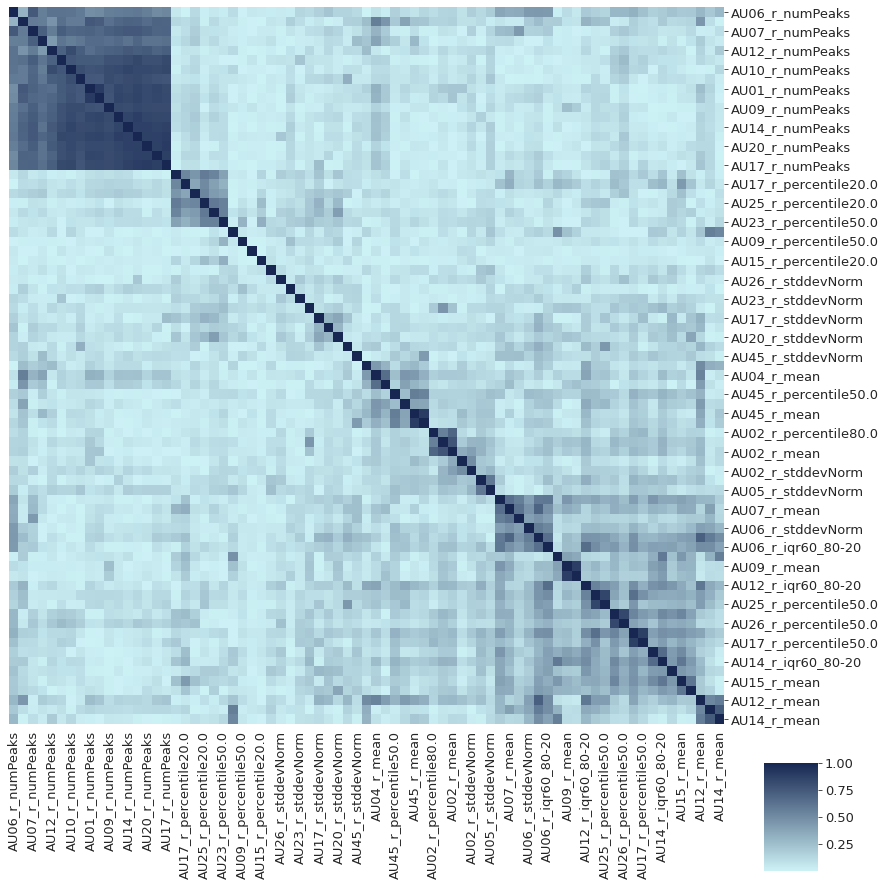

Number of dimensions before dimensionality reduction: 111
Number of dimensions after dimensionality reduction: 75


In [103]:
#XX = pd.DataFrame(data=X, columns=col_names)
yy = pd.Series(y)

# Create correlation matrix
corr_matrix = XX.corr().abs()

# https://youtu.be/ioXKxulmwVQ?t=899
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = corr_matrix.fillna(0)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than corr_tol (corelation tolerance)
corr_tol = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > corr_tol)]

# Drop features
df_tmp = XX.copy()
X_reduced = df_tmp.drop(df_tmp[to_drop], axis=1)

reduced_df = pd.concat([X_reduced, yy], axis=1)
reduced_df.to_csv(os.path.join(output_path, 'data', 'video_dataset_unsupervised_learning_reduced.csv'), index=None, header=True)

cg = sns.clustermap(X_reduced.corr().abs(), cmap=pos_cmap, metric='cityblock', cbar_pos=(0.88, 0.02, 0.05, 0.10), figsize=(15,15))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_xlim([0,0])
plt.savefig(os.path.join(output_path,'charts','corr_expl_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

print('Number of dimensions before dimensionality reduction:', len(XX.columns))
print('Number of dimensions after dimensionality reduction:', len(X_reduced.columns))

In [109]:
save_to = os.path.join(output_path, 'data', 'video_dataset_unsupervised_learning_reduced.npz')
np.savez(save_to, x=X_reduced.values, y=y, col_names=col_names)